# Импорт необходимых модулей

In [1]:
import sys
sys.path.append('..')

In [2]:
from source.code.utils import preprocessing

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from surprise import SVD
from surprise import NMF
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

# Загрузка данных

In [5]:
ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251', low_memory=False)

In [6]:
books = pd.read_csv('data/BX-Books.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251', low_memory=False)

In [7]:
users = pd.read_csv('data/BX-Users.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251', low_memory=False)

In [8]:
data_dict = {}
data_dict['books'] = books
data_dict['users'] = users
data_dict['ratings'] = ratings

# Предварительная обработка

In [9]:
preprocessed_data_dict = preprocessing(data_dict=data_dict, is_explicit=True, book_ratings_count_threshold=2, user_ratings_count_threshold=2)

In [10]:
preprocessed_data_dict['ratings'] = preprocessed_data_dict['ratings'].rename({'User-ID': 'userID', 'ISBN': 'itemID', 'Book-Rating': 'rating'}, axis='columns')

In [11]:
reader = Reader(rating_scale=(1, 10))

In [12]:
data = Dataset.load_from_df(preprocessed_data_dict['ratings'][['userID', 'itemID', 'rating']], reader)

# Тестирование различных алгоритмов на кросс-валидации

## Метрики - RMSE, MAE

### SVD

In [13]:
algo_svd = SVD()

In [14]:
svd_cv = cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6023  1.6054  1.5998  1.5971  1.5926  1.5994  0.0044  
MAE (testset)     1.2344  1.2396  1.2374  1.2338  1.2288  1.2348  0.0037  
Fit time          10.89   11.13   10.76   10.64   10.56   10.80   0.20    
Test time         0.39    0.33    0.31    0.27    0.26    0.31    0.05    


### NMF

In [15]:
algo_nmf = NMF()

In [16]:
nmf_cv = cross_validate(algo_nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.6372  2.6187  2.6196  2.6169  2.6532  2.6291  0.0141  
MAE (testset)     2.2527  2.2355  2.2355  2.2345  2.2675  2.2451  0.0131  
Fit time          15.34   15.25   15.23   15.35   15.09   15.25   0.09    
Test time         0.30    0.31    0.31    0.25    0.23    0.28    0.03    


### KNN (item-based)

In [17]:
sim_options = {
    'name': 'cosine',
    'user_based': False
}
algo_knn = KNNBasic(k=5, sim_options=sim_options)

In [18]:
knn_item_based_cv = cross_validate(algo_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8130  1.7902  1.8148  1.7978  1.7949  1.8021  0.0099  
MAE (testset)     1.3533  1.3380  1.3495  1.3429  1.3400  1.3447  0.0058  
Fit time          40.06   40.43   36.19   37.64   36.70   38.20   1.73    
Test time         3.12    3.11    3.55    3.16    3.36    3.26    0.17    


### KNN (user-based)

In [19]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}
algo_knn = KNNBasic(k=5, sim_options=sim_options)

In [20]:
knn_user_based_cv = cross_validate(algo_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9960  1.9982  1.9817  1.9853  2.0004  1.9923  0.0074  
MAE (testset)     1.5527  1.5527  1.5388  1.5424  1.5500  1.5473  0.0057  
Fit time          9.53    10.56   10.44   10.42   9.99    10.19   0.38    
Test time         1.09    1.11    1.06    1.04    1.09    1.08    0.02    


## Результаты тестирования

In [50]:
MEDIUM_SIZE = 40
BIGGER_SIZE = 50

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)
plt.rc('text', color='green')

plt.rc('xtick', color='green')
plt.rc('ytick', color='green')

plt.rc('axes', labelcolor='green')
plt.rc('axes', labelcolor='green')

In [69]:
def plot_results(cv_s, labels, folds):
    f, axs = plt.subplots(1, len(cv_s), figsize=(50, 15))
    for i, ax in enumerate(axs):
        ax.plot(cv_s[0][list(cv_s[0].keys())[i]], label=labels[0])
        ax.plot(cv_s[1][list(cv_s[1].keys())[i]], label=labels[1])
        ax.plot(cv_s[2][list(cv_s[2].keys())[i]], label=labels[2])
        ax.plot(cv_s[3][list(cv_s[3].keys())[i]], label=labels[3])
        ax.set_title('{} on {}-Fold cv'.format(list(cv_s[0].keys())[i], str(len(folds))))
        ax.legend()
        ax.grid(True)
    plt.setp(axs, xticks=range(len(folds)), xticklabels=folds)
    plt.tight_layout()
    plt.show()

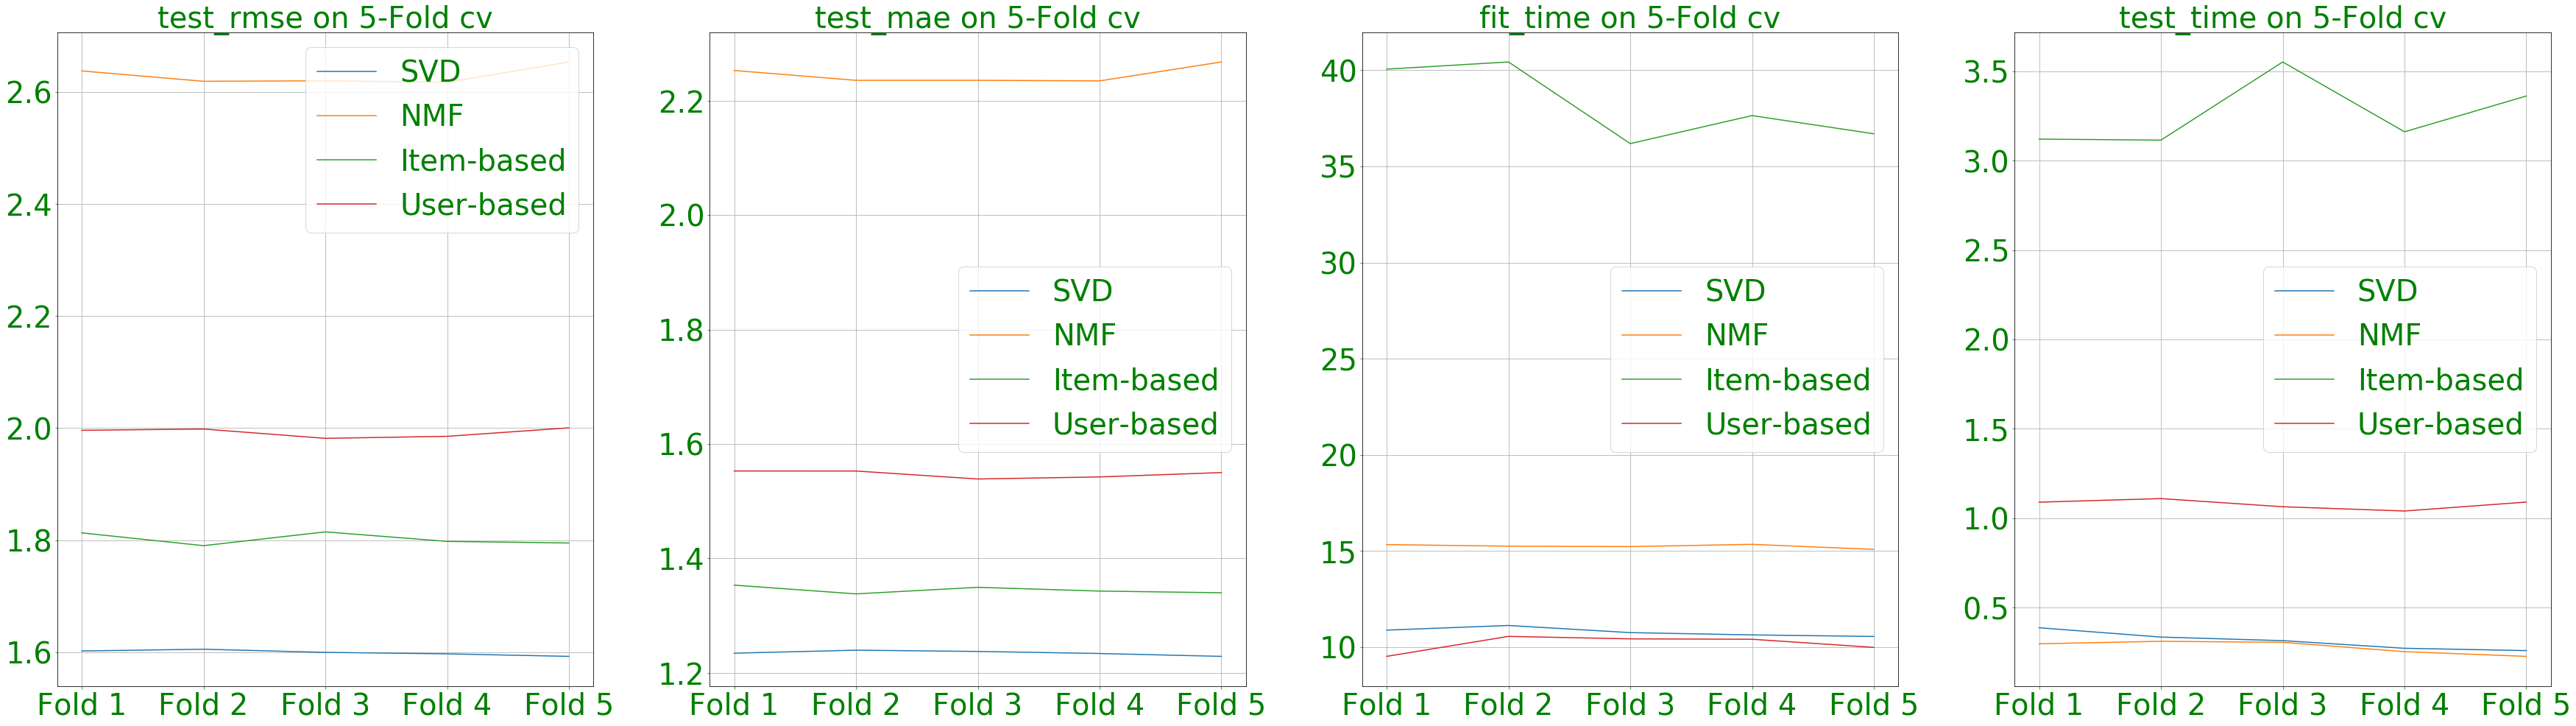

In [68]:
plot_results(
    [svd_cv, nmf_cv, knn_item_based_cv, knn_user_based_cv],
    ['SVD', 'NMF', 'Item-based', 'User-based'],
    ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
)